# TFcomb main tutorial

This notebook describes the main function of TFcomb to identify the reprogramming TFs from source state to target state. We also provided multiple visualization examples in this tutorial.

## import

In [1]:
import torch
import os
import scanpy as sc
import celloracle as co
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import TFcomb as tfc

In [3]:
import importlib
import TFcomb
importlib.reload(TFcomb.preprocessing.pca_umap)
importlib.reload(TFcomb.preprocessing.oracle_process)
importlib.reload(TFcomb.tools.utils)
importlib.reload(TFcomb.tools.GRN_func)
importlib.reload(TFcomb.tools.GNN_module)
importlib.reload(TFcomb.tools.link_recover)
importlib.reload(TFcomb.tools.link_recover_module)
importlib.reload(TFcomb.tools.tf_inference)
importlib.reload(TFcomb.plotting.plot)
importlib.reload(TFcomb.plotting.plot_grn)

<module 'TFcomb.plotting.plot_grn' from '/nfs/public/lichen/code/TFcomb_github_doc/TFcomb/TFcomb/plotting/plot_grn.py'>

## Read processed adata

In [4]:
data_dir = '../../data/iPSC_example/RNA_data'
save_dir = '../../data/iPSC_example/save' # create the folder to save results
os.makedirs(save_dir,exist_ok=True)

adata = sc.read(os.path.join(data_dir,'adata_rna.h5ad'))

# - ensure the cluster_name
cluster_name = 'celltype'

# - print basic info of the adata
print(f"Cell number is :{adata.shape[0]}")
print(f"Gene number is :{adata.shape[1]}")
print('the cluster_name count is:')
adata.obs[cluster_name].value_counts()

Cell number is :7841
Gene number is :1838
the cluster_name count is:


Fibroblasts    4665
iPSCs          3176
Name: celltype, dtype: int64

## Load base GRN & create celloracle object

In [5]:
# - load base GRN
base_GRN = pd.read_parquet(os.path.join('../../data/iPSC_example/base_GRN',"base_GRN_dataframe_stream.parquet"))
print(f"the base_GRN shape is {base_GRN.shape}")


# - train a pca and umap on the adata first, and input the adata to the oracle.
# the pca and umap model is for later visualize the transition
pca_train,umap_train, oracle = tfc.pp.pca_umap_train(adata,
                   cluster_column_name=cluster_name,
                   embedding_name="X_umap",
                   n_components=50,
                   svd_solver='arpack',
                   random_seed=2022)

the base_GRN shape is (31844, 1100)


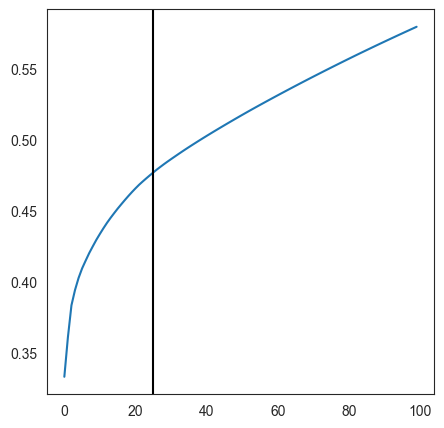

n_comps is: 25
cell number is :7841
Auto-selected k is :196
but we set default k is: 10


In [6]:
# - import the base_GRN to the oracle , and do the imputation
oracle.import_TF_data(TF_info_matrix=base_GRN)
oracle = tfc.pp.oracle_preprocess(oracle)
oracle.adata.obs['total'] = 'total'

## Construct a total GRN for all cells

  0%|          | 0/1 [00:00<?, ?it/s]

Inferring GRN for total...


  0%|          | 0/1617 [00:00<?, ?it/s]

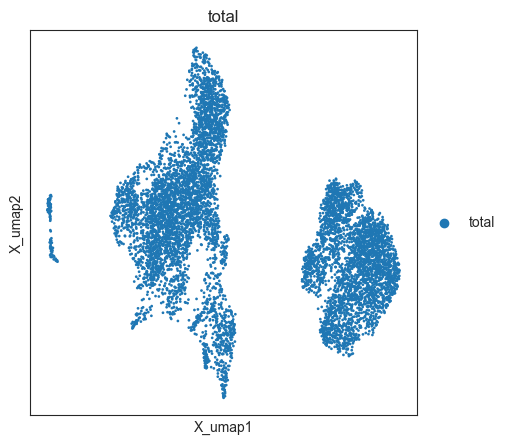

CPU times: user 2min 9s, sys: 12.1 s, total: 2min 21s
Wall time: 3min 9s


In [7]:
%%time
# Calculate GRN for each population in "louvain_annot" clustering unit.
# This step may take some time.
cluster_name_for_GRN_unit = cluster_name
links = oracle.get_links(cluster_name_for_GRN_unit='total', 
                         alpha=10,
                         verbose_level=10) # 值得注意的在计算link的时候用的都是oracle.adata的imputed count

In [8]:
# save oracle and links
os.makedirs(os.path.join(save_dir, 'oracle'), exist_ok = True)
oracle.to_hdf5(os.path.join(save_dir, 'oracle', "data.celloracle.oracle"))
links.to_hdf5(file_path=os.path.join(save_dir, 'oracle', "links.celloracle.links"))

## Load saved oracle data and links

In [9]:
# - read oracle and links
oracle = co.load_hdf5(os.path.join(save_dir, 'oracle', "data.celloracle.oracle"))
links = co.load_hdf5(file_path=os.path.join(save_dir, 'oracle', "links.celloracle.links"))

# get the processed adata from oracle
adata = oracle.adata.copy() 
adata.X = adata.layers['normalized_count'].toarray()  # here we make the data sparse, not sure if there are problems

In [10]:
# - load total TF list from the base GRN
TFdict = tfc.tl.import_TF_data(TF_info_matrix=base_GRN)

tf_target_dict = {}
for target, gene_set in TFdict.items():
    for tf in gene_set:
        if tf not in tf_target_dict:
            tf_target_dict[tf] = []
            tf_target_dict[tf].append(target)
        else:
            tf_target_dict[tf].append(target)
total_tf_list = list(tf_target_dict.keys())
print('len of total_tf_list: ', len(total_tf_list))

len of total_tf_list:  1098


## Infer the results with TFcomb

### Init the parameters

In [11]:
adata.obs[cluster_name].value_counts()

Fibroblasts    4665
iPSCs          3176
Name: celltype, dtype: int64

In [12]:
# - set the ground-truth TFs
gt_tfs = ['POU5F1', 'MYC', 'SOX2', 'NANOG', 'KLF4']

# - set source_state and target_state
source_state, target_state = 'Fibroblasts', 'iPSCs'
combine = '_'.join([source_state, target_state])

# - init the save_dir to save results
save_dir_part = os.path.join(save_dir, combine)
os.makedirs(save_dir_part, exist_ok=True)

### Generate the CellOracle with only cells of source state and target state

In [13]:
col_name = 'combine'
if not os.path.exists(os.path.join(save_dir_part,"data.celloracle.oracle")):
    oracle_part = oracle.copy()
    oracle_part.adata = oracle.adata[oracle.adata.obs[cluster_name].isin([source_state, target_state])]
    oracle_part.adata.obs[col_name] = '_'.join([source_state, target_state])
    oracle_part.adata.obs[col_name] = oracle_part.adata.obs[col_name].astype('category')
    oracle_part.cluster_column_name = col_name
    oracle_part.adata.uns[f'{col_name}_colors'] = np.array(['#ead3c6'])
    # Calculate GRN for each population in "louvain_annot" clustering unit.
    # This step may take some time.
    links_part = oracle_part.get_links(cluster_name_for_GRN_unit=col_name, 
                                alpha=10,
                                verbose_level=10)


    oracle_part.to_hdf5(os.path.join(save_dir_part, "data.celloracle.oracle"))
    links_part.to_hdf5(file_path=os.path.join(save_dir_part, "links.celloracle.links"))
else:
    oracle_part = co.load_hdf5(os.path.join(save_dir_part, "data.celloracle.oracle"))
    links_part = co.load_hdf5(file_path=os.path.join(save_dir_part, "links.celloracle.links"))

print('finish oracle_links_part load')

  0%|          | 0/1 [00:00<?, ?it/s]

Inferring GRN for Fibroblasts_iPSCs...


  0%|          | 0/1617 [00:00<?, ?it/s]

finish oracle_links_part load


In [14]:
# set the link threshold and do inference again
threshold_number = 10000
alpha_fit_GRN = 10
links_part.filter_links(threshold_number=threshold_number,
                    p=0.001,
                    weight='coef_abs')
oracle_part.get_cluster_specific_TFdict_from_Links(links_object=links_part)
oracle_part.fit_GRN_for_simulation(alpha=alpha_fit_GRN,
                              use_cluster_specific_TFdict=True)

  0%|          | 0/1 [00:00<?, ?it/s]

In [15]:
# - get the GRN matrix
gene_GRN_mtx_ori, tf_GRN_mtx_ori, tf_GRN_dict_ori = tfc.tl.get_GRN_parameters(oracle_part, combine)

gene_GRN_mtx, tf_GRN_mtx = gene_GRN_mtx_ori, tf_GRN_mtx_ori

tf_list, gene_list = list(tf_GRN_mtx.index), list(tf_GRN_mtx.columns)

### Use GAT to enhance link [Optional]

This step is optional. If you suppose that your data has captured comprehensive regulatory links, you can skip this step.

The details of the gat_params can be refered at xxx.

In [16]:
gpu = 1
if torch.cuda.is_available():
    device='cuda'
    torch.cuda.set_device(gpu)
else:
    device='cpu'

gnn_params = {
    "n_splits": 10,
    "seed": 42,
    "neg_link_split": 'all',
    "model_name": 'GAT',
    "pred_name": 'mlp',
    "device": device
}

filter_params = {
    "count_fold": 9,
    "link_score_quantile": 0.1,
}

In [17]:
# - construct the graph dataset
adata_part = adata[adata.obs[cluster_name] == source_state]
dataset = tfc.tl.GRN_Dataset(adata_part, tf_GRN_mtx, tf_list)
graph = dataset[0]

print(graph)

save_dir_GNN = os.path.join(save_dir, 'GNN_result')
os.makedirs(save_dir_GNN, exist_ok=True)

Graph(num_nodes=1838, num_edges=10000,
      ndata_schemes={'feat': Scheme(shape=(4665,), dtype=torch.float32), 'label': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={'weight': Scheme(shape=(), dtype=torch.float64)})


fold 0


 61%|██████▏   | 922/1500 [00:38<00:24, 24.00it/s]


0.9841709999999999 0.942 0.942 0.942 0.942
EarlyStopping: run 923 epoch
AUC 0.9873569999999998
ACC 0.948
F1 0.948
precision 0.948
recall 0.948
the best epoch is 622
the best metric is 0.948


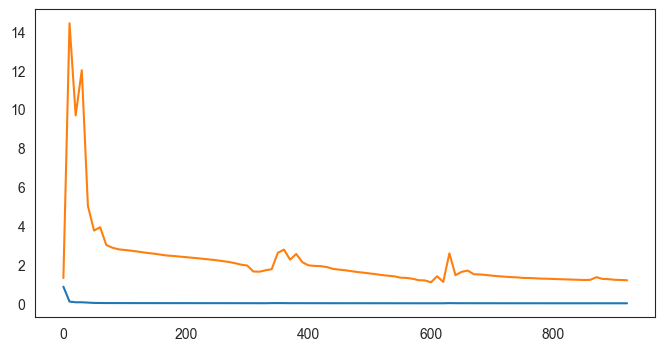

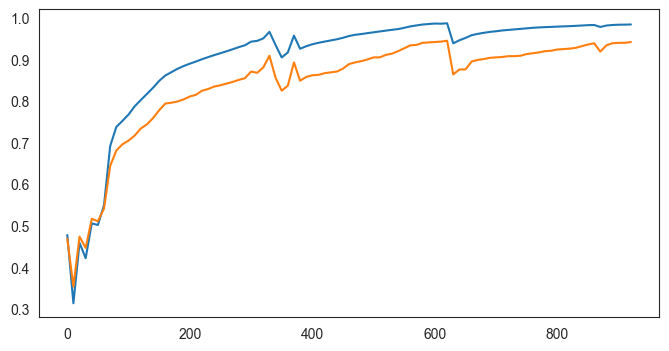

fold 1


 52%|█████▏    | 783/1500 [00:34<00:31, 22.89it/s]


0.9335459999999999 0.855 0.855 0.855 0.855
EarlyStopping: run 784 epoch
AUC 0.978197
ACC 0.937
F1 0.937
precision 0.937
recall 0.937
the best epoch is 483
the best metric is 0.937


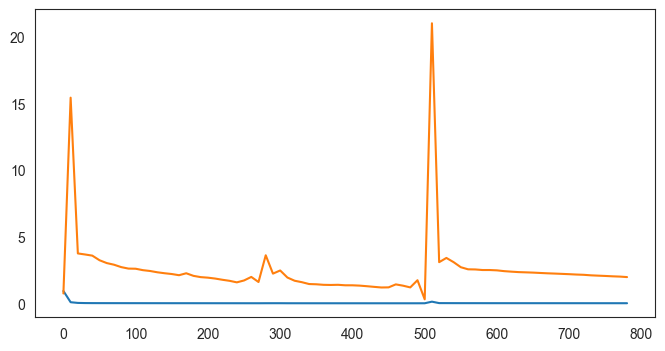

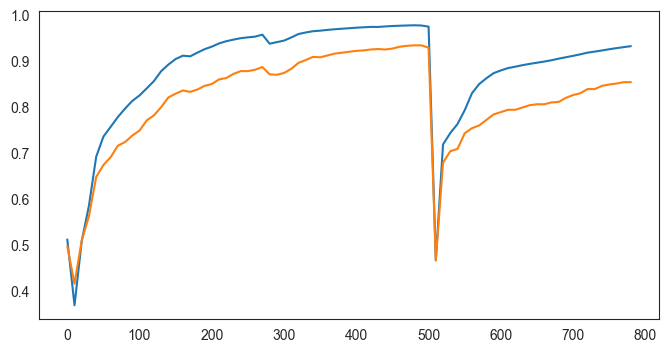

fold 2


 72%|███████▏  | 1084/1500 [00:46<00:17, 23.27it/s]


0.9809180000000001 0.944 0.944 0.944 0.944
EarlyStopping: run 1085 epoch
AUC 0.9822805000000001
ACC 0.951
F1 0.951
precision 0.951
recall 0.951
the best epoch is 784
the best metric is 0.951


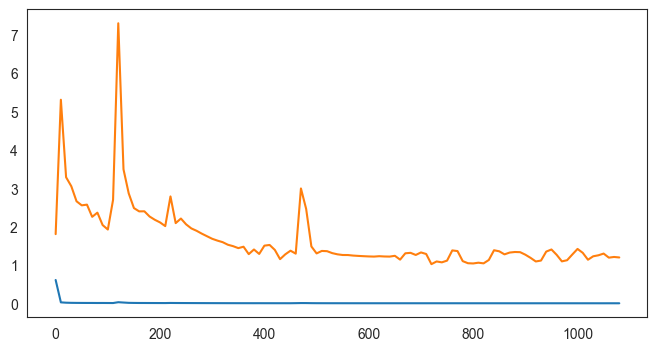

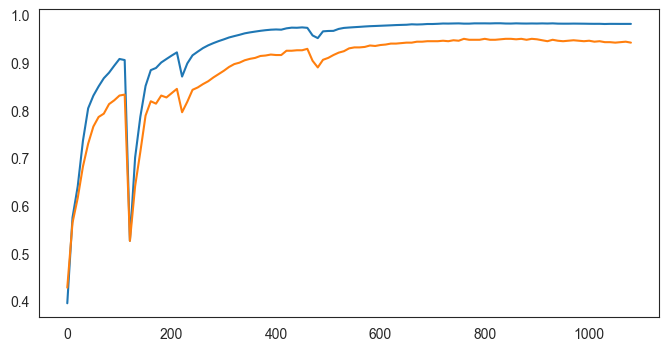

fold 3


 69%|██████▉   | 1035/1500 [00:43<00:19, 24.05it/s]


0.9803724999999999 0.949 0.949 0.949 0.949
EarlyStopping: run 1036 epoch
AUC 0.9805830000000001
ACC 0.952
F1 0.952
precision 0.952
recall 0.952
the best epoch is 735
the best metric is 0.952


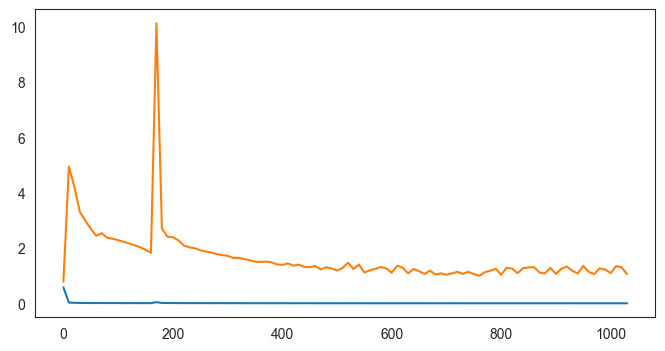

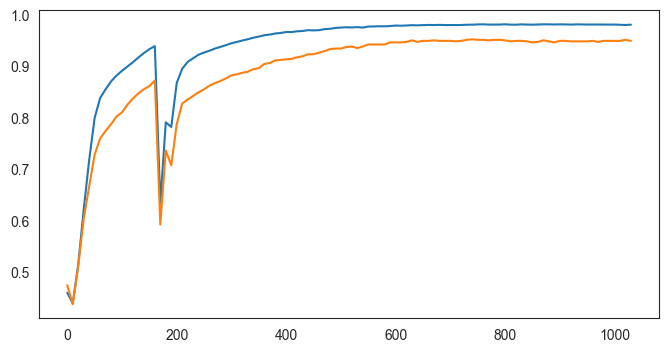

fold 4


100%|██████████| 1500/1500 [01:01<00:00, 24.37it/s]


AUC 0.9805659999999999
ACC 0.94
F1 0.94
precision 0.94
recall 0.94
the best epoch is 1332
the best metric is 0.94


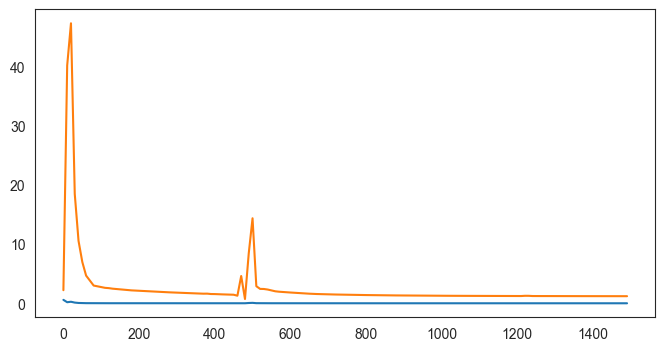

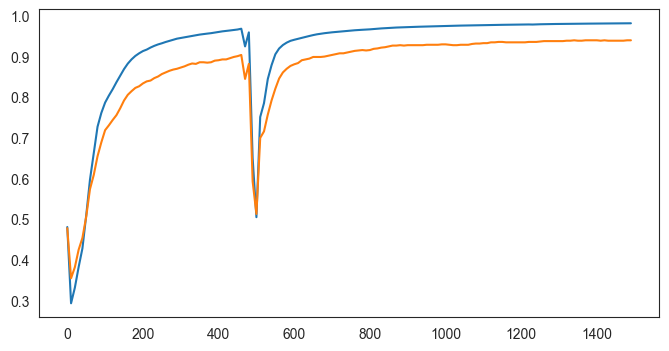

fold 5


 79%|███████▉  | 1189/1500 [00:53<00:14, 22.11it/s]


0.993446 0.97 0.97 0.97 0.97
EarlyStopping: run 1190 epoch
AUC 0.9928455
ACC 0.971
F1 0.971
precision 0.971
recall 0.971
the best epoch is 889
the best metric is 0.971


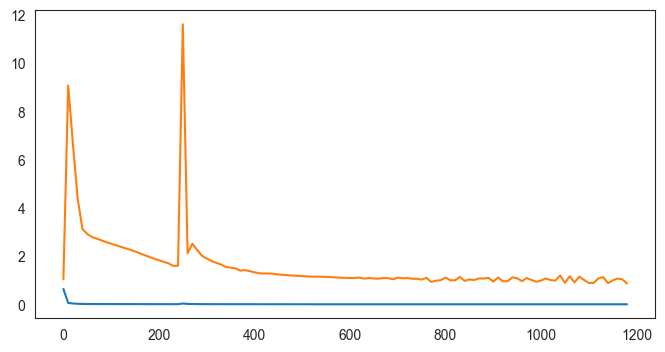

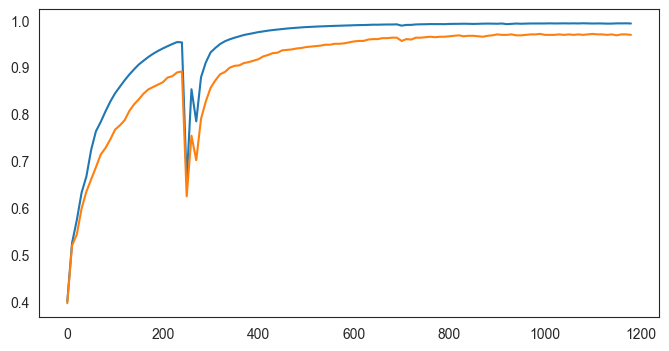

fold 6


100%|██████████| 1500/1500 [01:02<00:00, 23.87it/s]


AUC 0.987014
ACC 0.955
F1 0.955
precision 0.955
recall 0.955
the best epoch is 1310
the best metric is 0.955


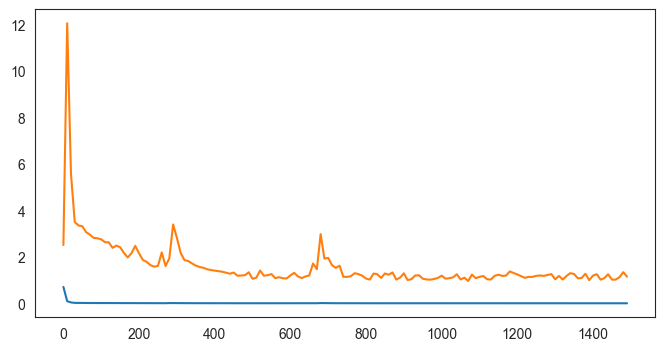

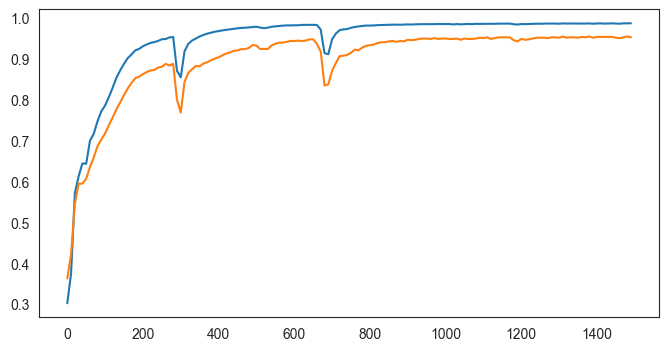

fold 7


 86%|████████▌ | 1293/1500 [00:52<00:08, 24.82it/s]


0.987067 0.956 0.956 0.956 0.956
EarlyStopping: run 1294 epoch
AUC 0.988479
ACC 0.964
F1 0.964
precision 0.964
recall 0.964
the best epoch is 993
the best metric is 0.964


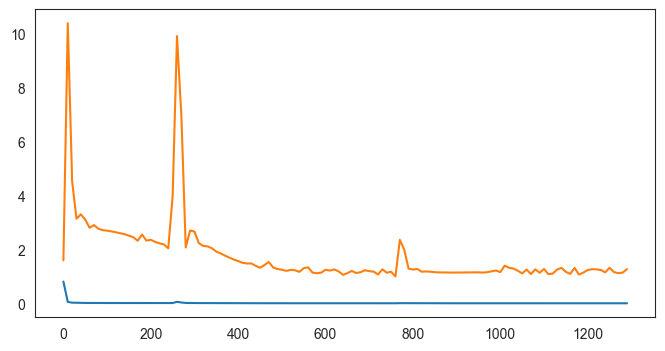

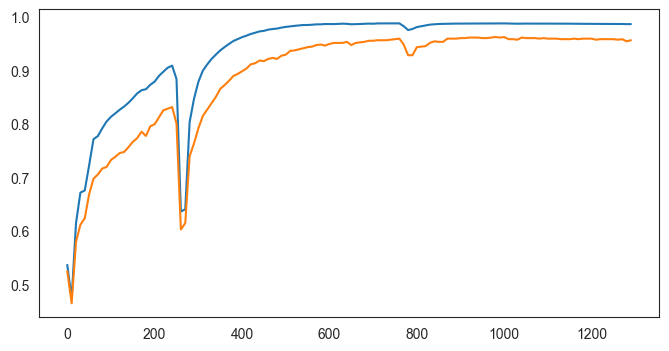

fold 8


 43%|████▎     | 643/1500 [00:27<00:36, 23.23it/s]


0.979006 0.938 0.938 0.938 0.938
EarlyStopping: run 644 epoch
AUC 0.97744
ACC 0.95
F1 0.9500000000000001
precision 0.95
recall 0.95
the best epoch is 343
the best metric is 0.95


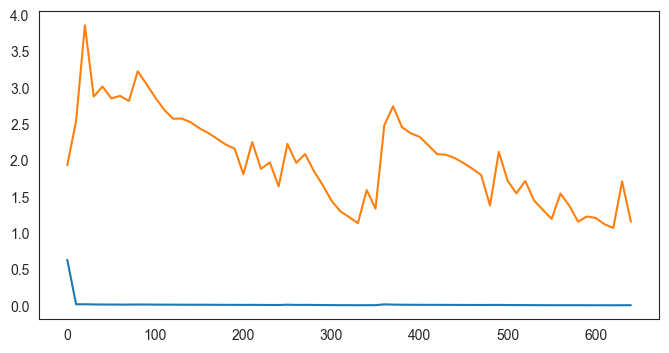

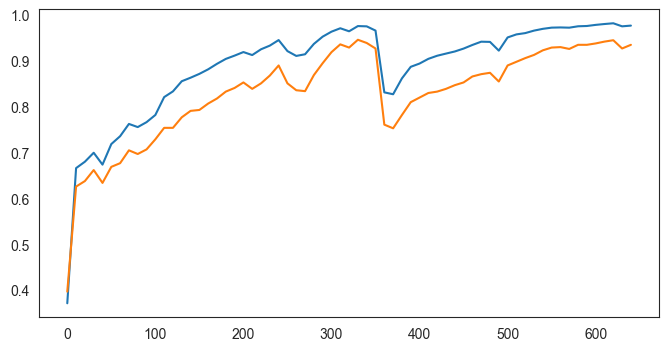

fold 9


 77%|███████▋  | 1150/1500 [00:46<00:14, 24.55it/s]


0.98052 0.949 0.949 0.949 0.949
EarlyStopping: run 1151 epoch
AUC 0.984112
ACC 0.954
F1 0.954
precision 0.954
recall 0.954
the best epoch is 850
the best metric is 0.954


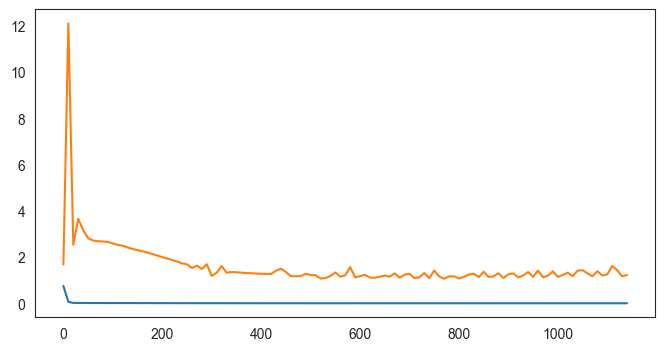

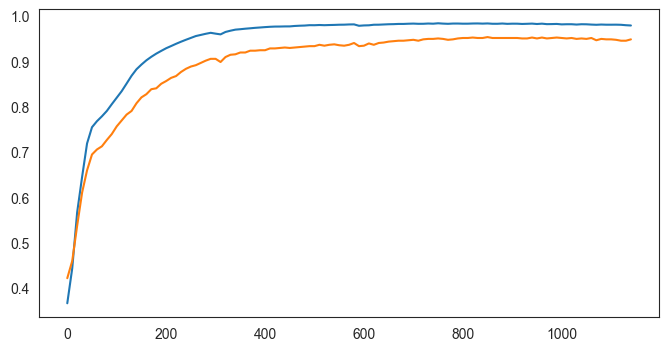

  0%|          | 0/1 [00:00<?, ?it/s]

In [18]:
# - run GAT_recover_links
gene_GRN_mtx, tf_GRN_mtx, tf_GRN_dict, links_recover = tfc.tl.GAT_recover_links(
                    g = graph,
                    save_dir_GNN = save_dir_GNN,
                    tf_list = tf_list,
                    gene_list = gene_list,
                    tf_GRN_dict = tf_GRN_dict_ori,
                    oracle_part = oracle_part,
                    links_part = links_part,
                    combine = combine,
                    
                    **gnn_params,
                    **filter_params,
)

In [19]:
# - updata tf list and gene list
tf_list, gene_list = list(tf_GRN_mtx.index), list(tf_GRN_mtx.columns)

### Solve the inverse problem and obtain the expected alterations

In [20]:
# - init the save_dir to save figures
save_dir_fig = os.path.join(save_dir, 'figures')
os.makedirs(save_dir_fig, exist_ok=True)

tf_infer_params = {
    "layer_use": 'normalized_count',
    "model": 'ridge',
    "alpha": 1,
    "a1": 0.6,
    "a2": 0.2,
    "a3": 0.2,
    "save": os.path.join(save_dir_fig,'regression_coef.png')
}

==========model:ridge, alpha:1
correlation is: 0.9641523233486307


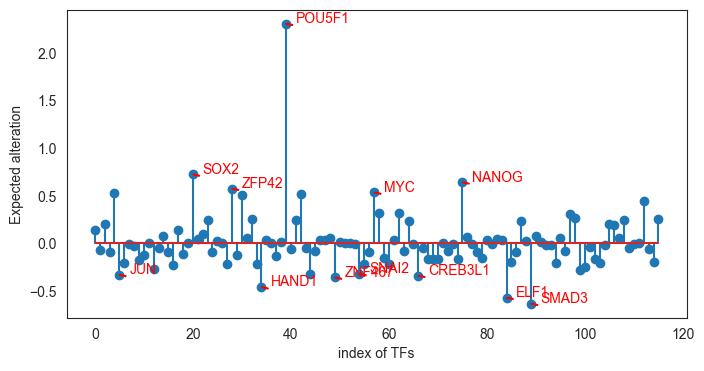

In [21]:
plt.rcParams["figure.figsize"] = [8, 4]
rr, X, source_ave, target_ave = tfc.tl.TF_inference(
                adata,
                cluster_name,
                tf_list,
                tf_GRN_mtx,
                gene_GRN_mtx,
                tf_GRN_mtx_ori,
                gene_GRN_mtx_ori,
                source_state,
                target_state,
                **tf_infer_params)

### Obtain directing scores

In [22]:
TF_ds_dict, _ = tfc.tl.get_directing_score(
                    tf_list,
                    rr,
                    tf_GRN_mtx,
                    tf_GRN_dict,
                    diff_ave = (target_ave - source_ave).ravel(),
                    )

### Plot results

First, we calculate the DE genes to annotate in our figures.

In [23]:
pos_genes, neg_genes, pos_tfs, neg_tfs = tfc.tl.get_de_genes(
                    adata,
                    cluster_name,
                    source_state,
                    target_state,
                    tf_list,
                    p_val=0.05)

Plot the scatter plots to show the directing scores and expected alterations for all TFs.

In [24]:
# - get the percentage to show TFs
x_name, y_name = 'Expected alteration', 'Directing score'
TF_number = 20 # top show TFs

df = pd.DataFrame({'index':tf_list + tf_list,
                    'value':list(rr.coef_) + list(TF_ds_dict.values()),
                    'cluster':[x_name]*len(rr.coef_) + [y_name]*len(rr.coef_)})

percentile = tfc.tl.get_percentile_thre(df, 'value', True, x_name, y_name, TF_number)

the percentile threshold is 75.0


In [25]:
plot_score_params = {
    "cluster1": x_name,
    "cluster2": y_name,
    "percentile1": percentile,
    "percentile2": percentile,
    "de_genes": list(pos_genes) + list(neg_genes),
    "gt_tfs": gt_tfs,
    "title": '->'.join([source_state, target_state]),
    "plot_all_tf": False,
    "goi_size": 10, 
    "point_size": 15,
    "save": os.path.join(save_dir_fig,'score.png'),
}

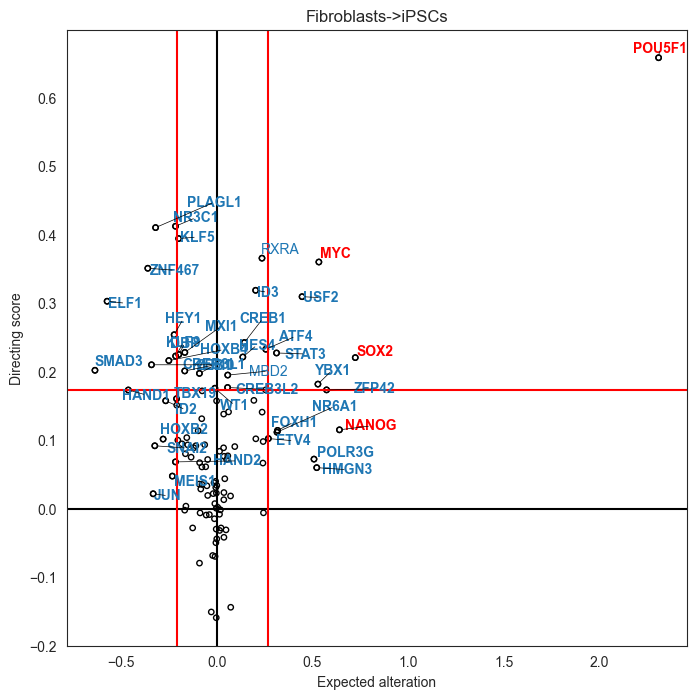

In [26]:
plt.rcParams["figure.figsize"] = [8, 8]
change_tf = tfc.pl.plot_score_comparison(
                            df, 
                            value='value', 
                            **plot_score_params)

Plot GRN.

In [27]:
# - get the score list, if you want to get the TFs for overexpression, set the direction to 'pos'
df_score = tfc.tl.get_single_TF(
    tf_list,
    rr,
    TF_ds_dict,
    direction = 'pos')
df_score.head()

,TF,directing_score,expected_alteration
0,POU5F1,0.658345,2.307519
1,RXRA,0.365671,0.237054
2,MYC,0.360068,0.533985
3,ID3,0.318769,0.203920
4,USF2,0.309472,0.446271


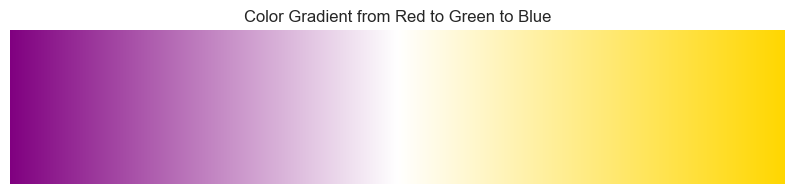

In [28]:
gene_color_dict = tfc.pl.get_gene_color_dict(oracle_part,
                                      source_state)

In [29]:
# - get tf_GRN_dict_delta
tf_GRN_dict_delta = {}
for key_1, dict_1 in tf_GRN_dict.items():
    tf_GRN_dict_delta[key_1] = {key_2:value for key_2, value in dict_1.items() if key_2 not in tf_GRN_dict_ori[key_1]}

# - set plot TFs
plot_tf_list = list(df_score['TF'][0:10])    

recover_tf_list, recover_pair_list = [], []
for tf in plot_tf_list:
    recover_tf_list.extend(list(tf_GRN_dict_delta[tf].keys()))
    recover_pair_list.extend([f'{tf}_{target}' for target in list(tf_GRN_dict_delta[tf].keys())])
recover_tfs = np.unique(recover_tf_list)
    

Note: `pygraphviz` should be installed to plot the GRN. Refer [here](https://pygraphviz.github.io/documentation/stable/install.html) for the installation.

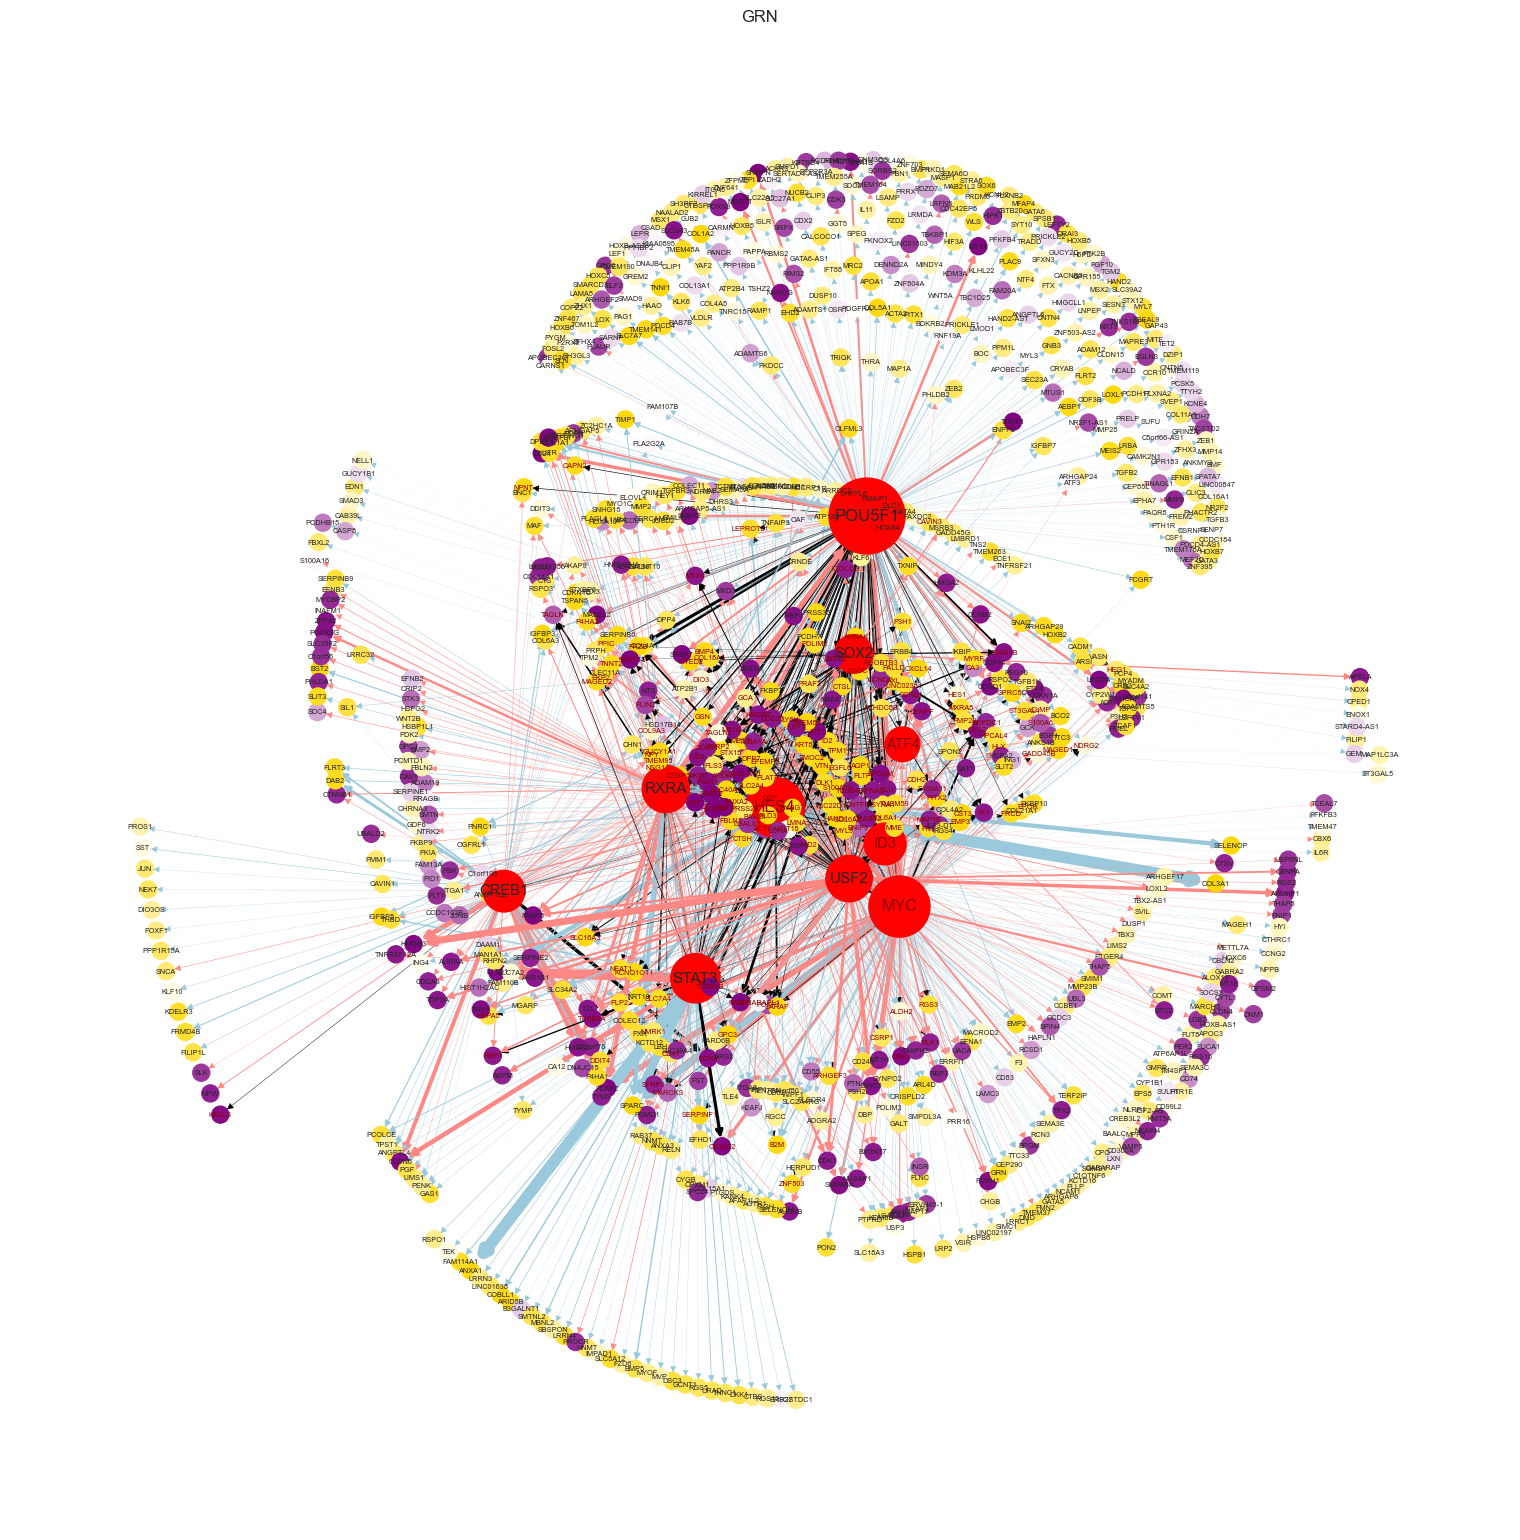

In [30]:
tfc.pl.plot_GRN(tf_GRN_dict = tf_GRN_dict,
                plot_tf_list = plot_tf_list, # plot top 10 TFs 
                save_dir_GRN = os.path.join(save_dir_fig,'GRN.png'),
                filter_link = False,
                anno_tfs = recover_tfs,
                anno_edges = recover_pair_list,
                show_mode = True,
                figsize = (15,15),
                gene_color_dict = gene_color_dict)

### Calculate TIS score

In [31]:
tis_score = tfc.tl.get_benchmark_score(gt_tfs, plot_tf_list)
print('TIS is: ', tis_score)

TIS is:  0.44


### Infer TF combiantions

In [32]:
df_score_combo = tfc.tl.get_multi_TF(
    tf_list,
    rr,
    tf_GRN_mtx,
    tf_GRN_dict,
    source_ave,
    target_ave,
    direction = 'pos',
    number = 3)

100%|██████████| 19600/19600 [00:09<00:00, 2100.71it/s]


In [33]:
df_score_combo.head()

,TF_combination,directing_score
0,"(POU5F1, MYC, NANOG)",0.766688
1,"(POU5F1, MYC, USF2)",0.755908
2,"(SOX2, POU5F1, MYC)",0.755667
3,"(POU5F1, MYC, RXRA)",0.752582
4,"(POU5F1, MYC, STAT3)",0.750849
